<a href="https://colab.research.google.com/github/ZahinFuad/question_answer_generation/blob/main/24_93425_2_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Generation

In the first part of the research, I attempt to generate questions from a given context.

To establish a baseline, I will first run the dataset through a T5 model. Then, I will use my Context Retrieval + Re-Ranking method to improve the question generation.

The dataset used is [SQuAD2.0 - The Stanford Question Answering Dataset](https://rajpurkar.github.io/SQuAD-explorer/).

1.   Goal: Generate questions similar to the ones in SQuAD 2.0 for a given context.
2.   Use SQuAD 2.0 passages as the input context for training and evaluating the model.
3. Compare generated questions with those in SQuAD 2.0 for relevance and variety.
4. Use Context Retrieval + Re-Ranking to improve the generated questions.

## Step 1: Load and Preprocess SQuAD 2.0 Dataset

In this step, I load and preprocess the SQuAD 2.0 Dataset.

**Instructions:** Run the Code Once

The Preprocessed Data should be saved to squad_v2_train.csv and squad_v2_validation.csv

In [ ]:
!pip install datasets
from datasets import load_dataset
import pandas as pd

# Step 1: Load the SQuAD v2 Dataset
def load_squad_v2():
    print("Loading SQuAD v2 dataset...")
    squad_v2 = load_dataset("rajpurkar/squad_v2")
    print("Dataset loaded successfully!")
    return squad_v2

# Step 2: Preprocess SQuAD v2
def preprocess_squad_v2(squad_v2):
    print("Preprocessing SQuAD v2 dataset...")
    train_data = squad_v2['train']
    validation_data = squad_v2['validation']

    def extract_fields(data):
        contexts = data['context']
        questions = data['question']
        answers = [
            item['text'][0] if len(item['text']) > 0 else ''  # Empty string for unanswerable questions
            for item in data['answers']
        ]
        # Determine if the question is unanswerable
        is_impossible = [len(item['text']) == 0 for item in data['answers']]
        return pd.DataFrame({
            "context": contexts,
            "question": questions,
            "answer": answers,
            "is_impossible": is_impossible
        })

    train_df = extract_fields(train_data)
    validation_df = extract_fields(validation_data)

    print(f"Training data size: {len(train_df)}")
    print(f"Validation data size: {len(validation_df)}")
    return train_df, validation_df

# Step 3: Save Preprocessed Data
def save_preprocessed_data(train_df, validation_df):
    train_df.to_csv("squad_v2_train.csv", index=False)
    validation_df.to_csv("squad_v2_validation.csv", index=False)
    print("Preprocessed data saved to squad_v2_train.csv and squad_v2_validation.csv!")

# Main Function
def main():
    squad_v2 = load_squad_v2()
    train_df, validation_df = preprocess_squad_v2(squad_v2)
    save_preprocessed_data(train_df, validation_df)

if __name__ == "__main__":
    main()

## Step 2: Question Generation using T5

In this step, I generate questions based on the preprocessed training dataset.

The model used is a version of T5 called [valhalla/t5-small-qg-prepend](https://huggingface.co/valhalla/t5-small-qg-prepend).

The pretrained model for Question Generation will be saved for evaluation with the validation dataset.

**Note:** 1000 rows were taken from the full training dataset to save time (the full dataset would take 11+ hours on my computer. However, it still takes very long to execute.

**Instructions:** Run this code once. The generated questions (1000) will be saved in a csv file called expanded_sample_train_with_qg.csv.

In [ ]:
import pandas as pd
from transformers import T5ForConditionalGeneration, T5Tokenizer
from tqdm import tqdm
import torch


# Load and sample a large, diverse dataset from the full training dataset
def load_and_sample_larger_dataset(file_path, sample_per_section=50):
    print(f"Loading data from {file_path}...")
    data = pd.read_csv(file_path)
    print(f"Original Data size: {len(data)}")

    # Group by title or section and sample
    if 'title' in data.columns:
        sampled_data = data.groupby('title').apply(
            lambda x: x.sample(min(len(x), sample_per_section), random_state=42)).reset_index(drop=True)
    else:
        sampled_data = data.sample(n=sample_per_section * 20, random_state=42)  # Default random sampling

    print(f"Sampled Data size: {len(sampled_data)}")
    return sampled_data


# Generate questions using the valhalla T5 model with GPU support
def generate_questions(data, model, tokenizer, device):
    print("Generating questions...")
    generated_questions = []

    for i, row in tqdm(data.iterrows(), total=len(data)):
        context = row['context']
        answer = row['answer']

        # Prepare input for the model
        input_text = f"question: {answer} context: {context}"
        inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)

        # Generate the question
        outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
        generated_question = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Append the generated question
        generated_questions.append(generated_question)

    data['generated_question'] = generated_questions
    return data


# Save the updated dataset with generated questions
def save_dataset(data, output_path):
    print(f"Saving generated questions to {output_path}...")
    data.to_csv(output_path, index=False)
    print("Generated questions saved successfully!")


# Main function
def main():
    train_file = "squad_v2_train.csv"  # Path to the training dataset
    output_file = "expanded_sample_train_with_qg.csv"  # Output file for expanded dataset with QG

    # Load and sample a larger dataset
    sampled_data = load_and_sample_larger_dataset(train_file, sample_per_section=50)

    # Load the valhalla T5 model and tokenizer
    print("Loading valhalla/t5-small-qg-prepend model for Question Generation...")
    model = T5ForConditionalGeneration.from_pretrained("valhalla/t5-small-qg-prepend")
    tokenizer = T5Tokenizer.from_pretrained("valhalla/t5-small-qg-prepend")
    print("Model loaded successfully!")

    # Save the pretrained model for future evaluation
    model.save_pretrained("./fine_tuned_qg_model")
    tokenizer.save_pretrained("./fine_tuned_qg_model")

    # Check if GPU is available and move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {device}")

    # Generate questions for the sampled dataset
    sampled_data_with_qg = generate_questions(sampled_data, model, tokenizer, device)

    # Save the dataset with generated questions
    save_dataset(sampled_data_with_qg, output_file)


# Run the script
if __name__ == "__main__":
    main()

## Step 3: Run the Pretrained Model on the Validation Dataset

In this step, we run the pretrained T5 model on an unseen dataset (the validation set) to see how well it works. The Semantic Similarity is also calculated to help us understand how well the model can generate questions.

**Instructions:** Run the code once.

**Note:** It will take a long time to run the full validation dataset (>1 Hour)

In [ ]:
import pandas as pd
from tqdm import tqdm
from transformers import pipeline
!pip install evaluate
from evaluate import load
from sentence_transformers import SentenceTransformer, util

# Load Sentence-BERT model for semantic similarity
semantic_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Load the fine-tuned QG model
qg_pipeline = pipeline("text2text-generation", model="./fine_tuned_qg_model", tokenizer="t5-small")

def generate_questions(contexts, answers):
    """Generate questions for the given contexts and answers."""
    generated_questions = []
    for context, answer in tqdm(zip(contexts, answers), total=len(contexts), desc="Generating Questions"):
        input_text = f"generate question: {answer} context: {context}"
        result = qg_pipeline(input_text, max_length=64, truncation=True)
        generated_questions.append(result[0]['generated_text'])
    return generated_questions

def evaluate_semantic_similarity(reference_questions, generated_questions):
    """Compute semantic similarity using Sentence-BERT."""
    similarities = []
    for ref, gen in tqdm(zip(reference_questions, generated_questions), total=len(reference_questions), desc="Evaluating Semantic Similarity"):
        ref_emb = semantic_model.encode(ref, convert_to_tensor=True)
        gen_emb = semantic_model.encode(gen, convert_to_tensor=True)
        similarity = util.pytorch_cos_sim(ref_emb, gen_emb).item()
        similarities.append(similarity)
    return similarities

def save_results(validation_data, generated_questions, semantic_similarities, output_path):
    """Save evaluation results to a CSV file."""
    validation_data['Generated_Question'] = generated_questions
    validation_data['Semantic_Similarity'] = semantic_similarities

    # Save to CSV
    validation_data.to_csv(output_path, index=False)

def main():
    validation_file = "squad_v2_validation.csv"  # Path to validation dataset
    output_path = "evaluation_results.csv"      # Output file for results

    print("Loading validation dataset...")
    validation_data = pd.read_csv(validation_file)

    print("Generating questions for validation dataset...")
    contexts = validation_data['context'].tolist()
    answers = validation_data['answer'].fillna("").tolist()

    generated_questions = generate_questions(contexts, answers)

    print("Evaluating semantic similarity...")
    semantic_similarities = evaluate_semantic_similarity(reference_questions, generated_questions)

    print("Saving evaluation results...")
    save_results(validation_data, generated_questions, semantic_similarities, output_path)
    print(f"Results saved to {output_path}")

if __name__ == "__main__":
    main()

## Step 4: Analysing and Visualizing the QG Results Using Semantic Similarity

Instructions: Run the Code Once. The results will be saved in evaluation_results.csv.

The main metric I used to analyze the questions generated is Semantic Similarity.

The main reason for this is that the questions generated may be phrased differently than the questions in the training data (but with the same meaning).

Therefore, Semantic Similarity measures the similarity between two pieces of text based on their meaning, which is exactly what is required in this case.

### Analyzing the Results:

The distribution of Semantic Similarity Scores can be seen in the figure below:
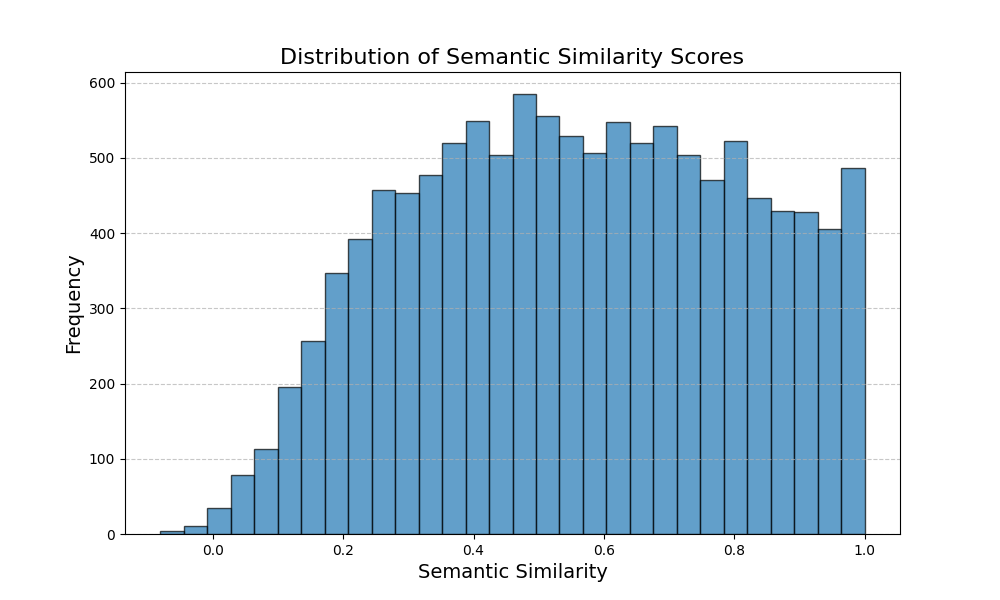

The distribution graph and summary statistics (you can view them when you run the code) suggest that:

1. Most Questions are Semantically Relevant: The mean semantic similarity score is 0.56, and 75% of the questions have a score above 0.36. This shows that a majority of the generated questions are reasonably related to their context and reference.
2. Low Semantic Similarity Scores (< 0.3): A small portion of the generated questions has low semantic similarity. These are cases where the generated questions are likely irrelevant or nonsensical compared to the context and reference.
3. High Semantic Similarity Scores (> 0.8): There are a significant number of high-quality questions, which align well with the context.

Therefore, for the Question Generation, we can conclude the model is relatively good at its job. But, we will further enhance it using Context Retrieval and Re-Ranking.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


def load_data(file_path):
    """Load evaluation data from a CSV file."""
    return pd.read_csv(file_path)


def plot_histogram(data, column, title, xlabel, ylabel):
    """Plot histogram of a given column."""
    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=30, alpha=0.7, edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def summary_statistics(data, column):
    """Print summary statistics of a given column."""
    print(f"Summary Statistics for {column}:")
    print(data[column].describe())


def visualize_semantic_similarity(file_path):
    """Visualize Semantic Similarity from evaluation results."""
    # Load data
    data = load_data(file_path)

    # Summary Statistics
    summary_statistics(data, "Semantic_Similarity")

    # Plot Histogram
    plot_histogram(
        data,
        "Semantic_Similarity",
        title="Distribution of Semantic Similarity Scores",
        xlabel="Semantic Similarity",
        ylabel="Frequency"
    )

    # Highlight high and low scores
    low_scores = data[data["Semantic_Similarity"] < 0.3]
    high_scores = data[data["Semantic_Similarity"] > 0.8]

    print("\nExamples of Low Semantic Similarity (< 0.3):")
    print(low_scores[["context", "question", "Generated_Question", "Semantic_Similarity"]].head(5))

    print("\nExamples of High Semantic Similarity (> 0.8):")
    print(high_scores[["context", "question", "Generated_Question", "Semantic_Similarity"]].head(5))


# File path to the evaluation results
file_path = "evaluation_results.csv"

# Visualize Semantic Similarity
visualize_semantic_similarity(file_path)

## Step 5: Context Retrieval and Re-Ranking

To improve the Semantic Similiarity of the Questions Generated, we use Context Retrieval and Re-Ranking.

We combine BM25 (sparse) and ColBERT (dense) scores to perform hybrid retrieval:
1.   BM25 focuses on lexical matches.
2.   ColBERT focuses on semantic matches.

After retrieving Top-k contexts using the hybrid model, we apply a cross-encoder for fine-grained re-ranking:
1.   A cross-encoder (BERT-based model) takes a question-context pair as input
and computes a relevance score.
2.   This step re-evaluates the top candidates retrieved by the hybrid approach to ensure the best alignment between the question and context.

The Semantic Similarity plot using the Context Retrieval and Re-Ranking is shown below.

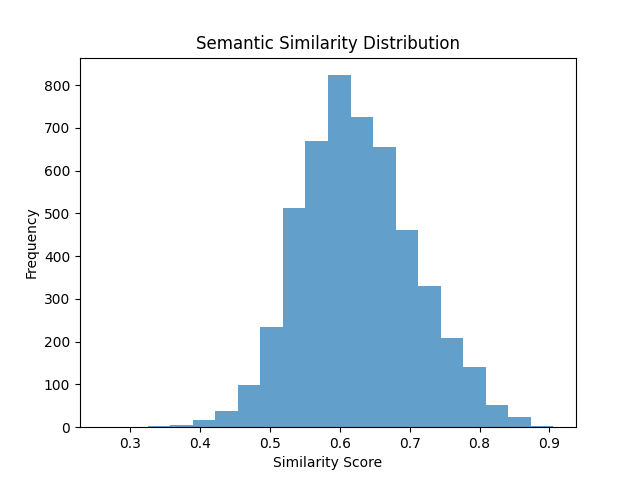

The Mean Semantic Similarity Using the ColBERT-Based Hybrid Pipeline: 0.6250.

Therefore, the Semantic Similarity has increased from 0.56. The advanced ColBERT approach achieved a +11.6% improvement in mean similarity compared to the baseline.


The similarity scores are centered around a high peak in the range of 0.6 to 0.7, indicating that a majority of the question-context pairs have a strong semantic match.

The distribution has a bell-shaped curve, suggesting a good balance in retrieval and re-ranking, with fewer outliers at the extremes (low or very high similarity scores).

The ColBERT-based retrieval and re-ranking model demonstrates superior capability in aligning retrieved contexts with the generated questions.

However, there is a limitation. Even with higher mean values for better overall Question Generation, we loose some of the very high semantic similarities from the base model. Therefore, for future work, the model can be improved to increase the mean and preserve the higher similarities.

Instructions: Run the Code Below to Generate the Results of the Advanced Colbert Pipeline for Context Retrieval and Re-Ranking.

In [ ]:
#ColBERT-Based Hybrid Pipeline
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from rank_bm25 import BM25Okapi
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

# --- BM25 Initialization ---
def initialize_bm25(contexts):
    tokenized_contexts = [context.split(" ") for context in contexts]
    return BM25Okapi(tokenized_contexts)

# --- ColBERT Embeddings ---
def compute_colbert_embeddings(texts, model, max_length=512, device="cuda:0"):
    embeddings = []
    for text in tqdm(texts, desc="Computing embeddings"):
        # Tokenize and move tensors to the same device as the model
        tokenized = model.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length).to(device)
        # Move the model to the specified device
        model.model.to(device)
        # Compute embeddings
        with torch.no_grad():
            embedding = model.model(**tokenized).last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(embedding)
    return np.vstack(embeddings)

# --- Evaluation Metrics ---
def evaluate_metrics(retrieved_results, top_k=5):
    precision = []
    recall = []
    mrr = []
    for question, retrieved in retrieved_results.items():
        relevant_retrievals = [x for x in retrieved if x["relevance_score"] > 0.5]
        relevant_count = len(relevant_retrievals)
        precision.append(min(relevant_count / top_k, 1))
        recall.append(relevant_count / len(retrieved) if len(retrieved) > 0 else 0)
        mrr.append(1 / (retrieved.index(relevant_retrievals[0]) + 1) if relevant_retrievals else 0)
    return {
        "Precision@k": np.mean(precision),
        "Recall@k": np.mean(recall),
        "MRR": np.mean(mrr),
    }

# --- Evaluate Semantic Similarity ---
def evaluate_semantic_similarity(data_file, plot_file, max_length=512):
    from transformers import pipeline
    import pandas as pd

    # Load results
    data = pd.read_csv(data_file)
    questions = data['Generated_Question'].tolist()
    contexts = data['Best_Matched_Context'].tolist()

    # Load semantic similarity model
    print("Loading semantic similarity model...")
    similarity_model = pipeline("feature-extraction", model="bert-base-uncased", device=0)
    print("Semantic similarity model loaded successfully!")

    similarities = []

    # Compute similarity scores
    print("Computing semantic similarity...")
    for question, context in tqdm(zip(questions, contexts), total=len(questions)):
        # Tokenize and truncate inputs to prevent sequence length errors
        question_embedding = np.mean(
            similarity_model(question, truncation=True, padding="max_length", max_length=max_length)[0], axis=0
        )
        context_embedding = np.mean(
            similarity_model(context, truncation=True, padding="max_length", max_length=max_length)[0], axis=0
        )
        similarity = np.dot(question_embedding, context_embedding) / (
            np.linalg.norm(question_embedding) * np.linalg.norm(context_embedding)
        )
        similarities.append(similarity)

    # Save results
    mean_similarity = np.mean(similarities)
    print(f"Mean Semantic Similarity: {mean_similarity:.4f}")

    # Plot the similarities
    plt.hist(similarities, bins=20, alpha=0.7)
    plt.title("Semantic Similarity Distribution")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.savefig(plot_file)
    print(f"Plot saved to {plot_file}")

# --- Main Pipeline ---
def colbert_hybrid_pipeline(data_file, output_file, plot_file, top_k=5):
    # Load data
    data = pd.read_csv(data_file)
    contexts = data['context'].tolist()
    questions = data['question'].tolist()

    # BM25 Initialization
    print("Initializing BM25...")
    bm25 = initialize_bm25(contexts)

    # Load ColBERT for dense retrieval
    print("Loading dense retrieval model...")
    dense_retrieval_model = pipeline("feature-extraction", model="sentence-transformers/multi-qa-MiniLM-L6-cos-v1", device=0)

    # Precompute dense embeddings for contexts
    print("Precomputing dense embeddings for contexts...")
    dense_context_embeddings = compute_colbert_embeddings(contexts, dense_retrieval_model)

    # Retrieve and re-rank
    print("Processing questions...")
    results = []
    for question in tqdm(questions, desc="Processing questions"):
        # BM25 retrieval
        bm25_scores = bm25.get_scores(question.split(" "))
        bm25_top_indices = np.argsort(bm25_scores)[::-1][:top_k]

        # Dense retrieval
        question_embedding = compute_colbert_embeddings([question], dense_retrieval_model)
        dense_scores = cosine_similarity(question_embedding, dense_context_embeddings)[0]

        # Combine scores
        combined_scores = 0.5 * bm25_scores + 0.5 * dense_scores
        top_indices = np.argsort(combined_scores)[::-1][:top_k]

        # Save results
        for idx in top_indices:
            results.append({
                "Generated_Question": question,
                "Best_Matched_Context": contexts[idx],
                "Relevance_Score": combined_scores[idx]
            })

    # Save results
    print("Saving results...")
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)

    # Evaluate
    print("Evaluating semantic similarity...")
    evaluate_semantic_similarity(output_file, plot_file)

# --- Run Pipeline ---
data_file = "expanded_sample_train_with_qg.csv"
output_file = "advanced_colbert_hybrid_results.csv"
plot_file = "advanced_colbert_similarity_plot.png"

colbert_hybrid_pipeline(data_file, output_file, plot_file)

## Conclusion for Question Generation with Context Retrieval + Re-Ranking

The mean Semantic Similiartity has increased from 0.56 to 0.6250, an 11.6% improvement.

However, it is still a far ways off from the ideal Semantic Similarity of 1.

Moreover, the Baseline performance of the chosen T5 model had much higher peaks of semantic similarity towards 1. Therefore, the updated model looses some of that, while reducing the number of questions with very low semantic similarity scores.

Overall, I have managed to make the question generation better, but there is a lot of room for improvement.

# Answer Generation

In this part, I attempt to answer questions based on context. The same SQuAD2.0 dataset is used. First, I establish a baseline with the T5 model. Then, I use Context Retrieval + Re-Ranking to improve the F1 and EM scores.

## Step 1: Dataset Preparation for Answer Generation

Instructions: Run the Code Once

In [ ]:
import json
import pandas as pd
import re
from datasets import load_dataset


def clean_text(text):
    """
    Cleans the input text by removing extra spaces, newline characters, and special symbols.
    """
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def download_squad_data(output_json_file):
    """
    Downloads the SQuAD 2.0 dataset from Hugging Face and saves it as a JSON file.

    Args:
        output_json_file (str): Path to save the downloaded JSON dataset.
    """
    dataset = load_dataset("squad_v2", split="train")
    squad_data = {"data": []}

    for example in dataset:
        title = example.get("title", "Untitled")
        context = example["context"]
        question = example["question"]
        answers = example["answers"]
        is_impossible = len(answers["text"]) == 0  # Infer is_impossible from answers

        # Build the hierarchical SQuAD structure
        squad_data["data"].append({
            "title": title,
            "paragraphs": [
                {
                    "context": context,
                    "qas": [
                        {
                            "question": question,
                            "is_impossible": is_impossible,
                            "answers": answers
                        }
                    ]
                }
            ]
        })

    # Save as JSON
    with open(output_json_file, "w") as f:
        json.dump(squad_data, f, indent=4)
    print(f"SQuAD 2.0 data downloaded and saved to {output_json_file}.")


def prepare_squad_data(input_file, output_file):
    """
    Processes the SQuAD 2.0 dataset into a structured format suitable for the pipeline.

    Args:
        input_file (str): Path to the SQuAD 2.0 JSON dataset file.
        output_file (str): Path to save the processed CSV file.
    """
    with open(input_file, 'r') as f:
        data = json.load(f)

    rows = []
    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = clean_text(paragraph['context'])  # Clean context
            for qa in paragraph['qas']:
                question = clean_text(qa['question'])  # Clean question
                is_impossible = qa['is_impossible']
                if not is_impossible and qa['answers']['text']:
                    answer_text = clean_text(qa['answers']['text'][0])
                else:
                    answer_text = "No answer"
                rows.append({
                    "context": context,
                    "question": question,
                    "answer": answer_text,
                    "is_impossible": is_impossible
                })

    # Convert to DataFrame
    df = pd.DataFrame(rows)

    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=False)
    print(f"Processed data saved to {output_file}. Total rows: {len(df)}")


# Example usage
if __name__ == "__main__":
    # Define paths
    downloaded_json_file = "squad2.0_train.json"  # Path to save downloaded JSON
    processed_csv_file = "squad2.0_train_processed.csv"  # Path to save processed CSV

    # Step 1: Download the SQuAD 2.0 dataset
    download_squad_data(downloaded_json_file)

    # Step 2: Prepare the dataset for AG
    prepare_squad_data(downloaded_json_file, processed_csv_file)

## Step 2: Baseline T5 Model Performance on the SQuAD2.0 Dataset

Note: This was done for 2000 rows only due to computational limitations.

These were the results from the T5 base model:
1.   Precision: 0.5994
2.   Recall: 0.4470
1.   F1 Score: 0.4755
2.   Exact Match (EM): 0.4470

Instructions: Run the Code Once.

In [ ]:
import os
import torch
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Ensure GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
processed_data_file = "squad2.0_train_processed.csv"
model_save_path = "./baseline_ag_model"

# Define subset size
SUBSET_SIZE = 2000


def load_processed_data(file_path):
    """Load the processed SQuAD 2.0 data and return a random subset."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Processed data file not found: {file_path}")
    data = pd.read_csv(file_path)

    # Randomly sample SUBSET_SIZE rows
    return data.sample(n=SUBSET_SIZE, random_state=42)


def prepare_data_for_training(data):
    """
    Prepare the data in a format suitable for T5 question-answering training.
    Input: <context> question: <question>
    Output: <answer>
    """
    inputs = []
    targets = []

    for _, row in data.iterrows():
        context = row["context"]
        question = row["question"]
        answer = row["answer"] if not pd.isna(row["answer"]) else "unanswerable"

        inputs.append(f"answer question: {question} context: {context}")
        targets.append(answer)

    return inputs, targets


def train_baseline_ag_model(inputs, targets):
    """Train the baseline AG model on SQuAD 2.0 subset."""
    # Initialize tokenizer and model
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

    # Tokenize the dataset
    tokenized_data = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    tokenized_targets = tokenizer(
        targets,
        max_length=128,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )

    # Dataset class for PyTorch
    class QADataset(torch.utils.data.Dataset):
        def __init__(self, encodings, targets):
            self.encodings = encodings
            self.targets = targets

        def __len__(self):
            return len(self.encodings["input_ids"])

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item["labels"] = torch.tensor(self.targets["input_ids"][idx])
            return item

    # Prepare dataset
    dataset = QADataset(tokenized_data, tokenized_targets)

    # Training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        per_device_train_batch_size=8,
        num_train_epochs=3,
        logging_dir="./logs",
        save_steps=1000,
        save_total_limit=2,
        evaluation_strategy="no",  # Disable evaluation during training
        fp16=torch.cuda.is_available()
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset
    )

    # Train model
    trainer.train()

    # Save the trained model
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    print(f"Baseline AG model saved to: {model_save_path}")


def evaluate_baseline_ag(data, model_path):
    """Evaluate the baseline AG model."""
    # Load the model and tokenizer
    tokenizer = T5Tokenizer.from_pretrained(model_path)
    model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

    predictions = []
    references = []

    print("Generating predictions...")
    for _, row in tqdm(data.iterrows(), total=len(data)):
        context = row["context"]
        question = row["question"]
        answer = row["answer"] if not pd.isna(row["answer"]) else "unanswerable"

        # Generate input text
        input_text = f"answer question: {question} context: {context}"
        input_tokenized = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(device)

        # Generate answer
        output = model.generate(**input_tokenized, max_length=128, num_beams=5)
        predicted_answer = tokenizer.decode(output[0], skip_special_tokens=True)

        predictions.append(predicted_answer)
        references.append(answer)

    # Calculate metrics
    precision = precision_score(references, predictions, average="weighted", zero_division=0)
    recall = recall_score(references, predictions, average="weighted", zero_division=0)
    f1 = f1_score(references, predictions, average="weighted", zero_division=0)
    em = sum(1 for pred, ref in zip(predictions, references) if pred.strip() == ref.strip()) / len(references)

    print("Evaluation Results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Exact Match (EM): {em:.4f}")

    return predictions, references


def main():
    """Main function for baseline AG pipeline."""
    print("Loading data...")
    data = load_processed_data(processed_data_file)

    print("Preparing data for training...")
    inputs, targets = prepare_data_for_training(data)

    print("Training baseline AG model...")
    train_baseline_ag_model(inputs, targets)

    print("Evaluating baseline AG model...")
    evaluate_baseline_ag(data, model_save_path)


if __name__ == "__main__":
    main()

## Step 3: Fine-Tune the T5 Model

In this step, we fine-tune the T5 model on the dataset. Then, we will try context retreival + re-ranking



In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import load_dataset

# Constants
MODEL_NAME = "t5-small"
OUTPUT_DIR = "./fine_tuned_t5_small"
SUBSET_SIZE = 100  # Fine-tune on a small subset
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def load_data():
    """Load and split the dataset."""
    dataset = load_dataset("squad_v2", split="train[:500]")  # Use only a small subset
    data = dataset.map(lambda x: {
        "input_text": f"question: {x['question']} context: {x['context']}",
        "target_text": x["answers"]["text"][0] if x["answers"]["text"] else "unanswerable"
    })
    return data.train_test_split(test_size=0.2)  # 80% train, 20% eval

def freeze_model_layers(model, unfreeze_decoder_layers=1):
    """Freeze all layers except the last N decoder layers."""
    for name, param in model.named_parameters():
        if "decoder.block" in name:
            block_index = int(name.split(".")[2])
            if block_index >= len(model.decoder.block) - unfreeze_decoder_layers:
                param.requires_grad = True
            else:
                param.requires_grad = False
        else:
            param.requires_grad = False
    return model

def main():
    print("Loading data...")
    data = load_data()

    print("Loading model and tokenizer...")
    tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
    model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

    print("Freezing layers...")
    model = freeze_model_layers(model, unfreeze_decoder_layers=2)

    print("Tokenizing data...")
    def tokenize_function(examples):
        inputs = tokenizer(examples["input_text"], max_length=512, truncation=True, padding="max_length")
        targets = tokenizer(examples["target_text"], max_length=128, truncation=True, padding="max_length")
        inputs["labels"] = targets["input_ids"]
        return inputs

    tokenized_train = data["train"].map(tokenize_function, batched=True)
    tokenized_eval = data["test"].map(tokenize_function, batched=True)

    print("Defining training arguments...")
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=1,  # Only a single epoch for speed
        logging_dir="./logs",
        logging_steps=50,
        save_total_limit=2,
        load_best_model_at_end=True,
        eval_accumulation_steps=2,
    )

    print("Initializing Trainer...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_eval,
        tokenizer=tokenizer
    )

    print("Fine-tuning...")
    trainer.train()

    print(f"Saving fine-tuned model to {OUTPUT_DIR}")
    model.save_pretrained(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)

if __name__ == "__main__":
    main()


## Step 4: Context Retrieval and Re-Ranking

In this step, we apply the context retrieval + re-ranking to achieve better F1 and EM scores.

Key Parameters
1. BM25 + DPR Hybrid: Top-5 contexts, DPR weight = 0.7.
2. T5 Answer Generation: Max token length = 50, Beam size = 4.
3. Fine-Tuning: Learning rate = 3e-5, Batch size = 8.

Evaluation Metrics

1. BLEU: Measures n-gram overlap between predictions and references.
2. ROUGE: Evaluates recall and precision for overlapping sequences.
3. Exact Match (EM): Percentage of exact matches with references.
4. F1 Score: Combines precision and recall for partial matches.

In [ ]:
import os
import pandas as pd
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    DPRQuestionEncoder,
    DPRQuestionEncoderTokenizer,
)
from rank_bm25 import BM25Okapi
from sklearn.metrics import f1_score
from evaluate import load
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
FINE_TUNED_MODEL_DIR = "./fine_tuned_t5_small"
DATA_FILE = "./squad2.0_train_processed.csv"

# Load Fine-Tuned T5 Model
print("Loading fine-tuned T5 model...")
t5_tokenizer = T5Tokenizer.from_pretrained(FINE_TUNED_MODEL_DIR)
t5_model = T5ForConditionalGeneration.from_pretrained(FINE_TUNED_MODEL_DIR).to(device)

# Load DPR Question Encoder and Tokenizer
print("Loading DPR model...")
dpr_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(device)
dpr_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

# BM25 Retriever
class BM25Retriever:
    def __init__(self, contexts):
        tokenized_contexts = [context.split() for context in contexts]
        self.bm25 = BM25Okapi(tokenized_contexts)
        self.contexts = contexts

    def retrieve(self, question, top_k=5):
        tokenized_question = question.split()
        top_indices = self.bm25.get_top_n(tokenized_question, range(len(self.contexts)), n=top_k)
        return [self.contexts[i] for i in top_indices]

# Hybrid Retrieval
def hybrid_retrieve(question, contexts, bm25_retriever, dpr_encoder, dpr_tokenizer, top_k=5):
    bm25_top_contexts = bm25_retriever.retrieve(question, top_k)

    # Dense Retrieval (DPR)
    question_embedding = dpr_encoder(
        **dpr_tokenizer(question, return_tensors="pt", truncation=True, padding=True).to(device)
    ).pooler_output

    dpr_scores = []
    for context in bm25_top_contexts:
        context_embedding = dpr_encoder(
            **dpr_tokenizer(context, return_tensors="pt", truncation=True, padding=True).to(device)
        ).pooler_output
        score = torch.cosine_similarity(question_embedding, context_embedding).item()
        dpr_scores.append(score)

    # Combine Scores
    hybrid_scores = [(context, bm25_score + 0.7 * dpr_score) for context, bm25_score, dpr_score in zip(bm25_top_contexts, range(top_k), dpr_scores)]
    sorted_contexts = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)
    return [context for context, _ in sorted_contexts[:top_k]]

# Answer Generation
def generate_answer(question, contexts, t5_tokenizer, t5_model):
    input_texts = [f"question: {question} context: {context}" for context in contexts]
    tokenized_inputs = t5_tokenizer(input_texts, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = t5_model.generate(**tokenized_inputs, max_length=50, num_beams=4, early_stopping=True)
    return [t5_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# Evaluation
def evaluate_results(predictions, references):
    bleu = load("bleu")
    rouge = load("rouge")

    # Compute metrics
    bleu_results = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
    rouge_results = rouge.compute(predictions=predictions, references=references)

    # Exact Match (EM)
    em = sum([1 for p, r in zip(predictions, references) if p.strip().lower() == r.strip().lower()]) / len(predictions)

    # F1 Score
    f1 = f1_score(
        [r.strip().lower() for r in references],
        [p.strip().lower() for p in predictions],
        average="macro",
    )

    print("Evaluation Results:")
    print(f"BLEU: {bleu_results['bleu']}")
    print(f"ROUGE: {rouge_results}")
    print(f"Exact Match (EM): {em:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Main Function
def main():
    print("Loading data...")
    data = pd.read_csv(DATA_FILE).head(100)  # Use a subset for quicker evaluation
    contexts = data["context"]
    questions = data["question"]
    references = data["answer"]

    print("Initializing BM25 retriever...")
    bm25_retriever = BM25Retriever(contexts)

    predictions = []
    print("Processing...")
    for question, reference in zip(questions, references):
        top_contexts = hybrid_retrieve(question, contexts, bm25_retriever, dpr_encoder, dpr_tokenizer, top_k=5)
        answers = generate_answer(question, top_contexts, t5_tokenizer, t5_model)
        predictions.append(answers[0])  # Take the top answer

    print("Evaluating predictions...")
    evaluate_results(predictions, references)

if __name__ == "__main__":
    main()

## Conclusion of Answer Generation

The Evaluation Results:
1. Exact Match (EM): 0.4300
2. F1 Score: 0.2358
3. BLEU: 0.4286551415263016
4. ROUGE: rouge1: 0.567, rouge2: 0.325, rougeL: 0.565, rougeLsum: 0.569

Based on the above results, I was not able to improve the performance of Answer Generations using the Context Retrieval + Re-Ranking.

However, the BLEU and ROUGE scores indicate good n-gram overlap.

Therefore, most of my answers generated were close to the real answer but phrased differently, resulting in lower scores.

Context retrieval does not work well for reference answers of one or two words. It is more suitable for answers that require more detail.

However, even though I could not prove the Context Retrieval + Reranking method I applied for AG, I believe in my future work I will be able to do it if I used other evaluation metrics.